# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(69)

## Load *Dataset*

In [2]:
# !gdown --id 1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg

Load data from the given pickle file

In [3]:
# mount Google Drive to access the dataset

# load the data set
with open('train_data.pkl','rb') as f:
    data = pickle.load(f)

# split into features and labels
x = data['X'][:5000]
y = data['y'][:5000]

# normalize
x = x/255.0

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(test_size=0.2, random_state=420)
for train_idx, test_idx in ss.split(x,y):
    train_x, train_y = x[train_idx], y[train_idx]
    test_x, test_y = x[test_idx], y[test_idx]

In [4]:
from collections import Counter
Counter(y.reshape(-1,))

Counter({6: 468,
         9: 482,
         8: 496,
         1: 592,
         0: 499,
         5: 445,
         7: 515,
         4: 497,
         2: 509,
         3: 497})

In [5]:
# make labels categorical
def to_categorical(x):
    x_cat = []
    size = int(np.max(x)+1)
    eye = np.eye(size)
    for i in x:
        x_cat.append(eye[i[0]])

    return np.array(x_cat)

train_y, test_y = to_categorical(train_y), to_categorical(test_y)

In [7]:
# sanity check
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4000, 784) (4000, 10) (1000, 784) (1000, 10)


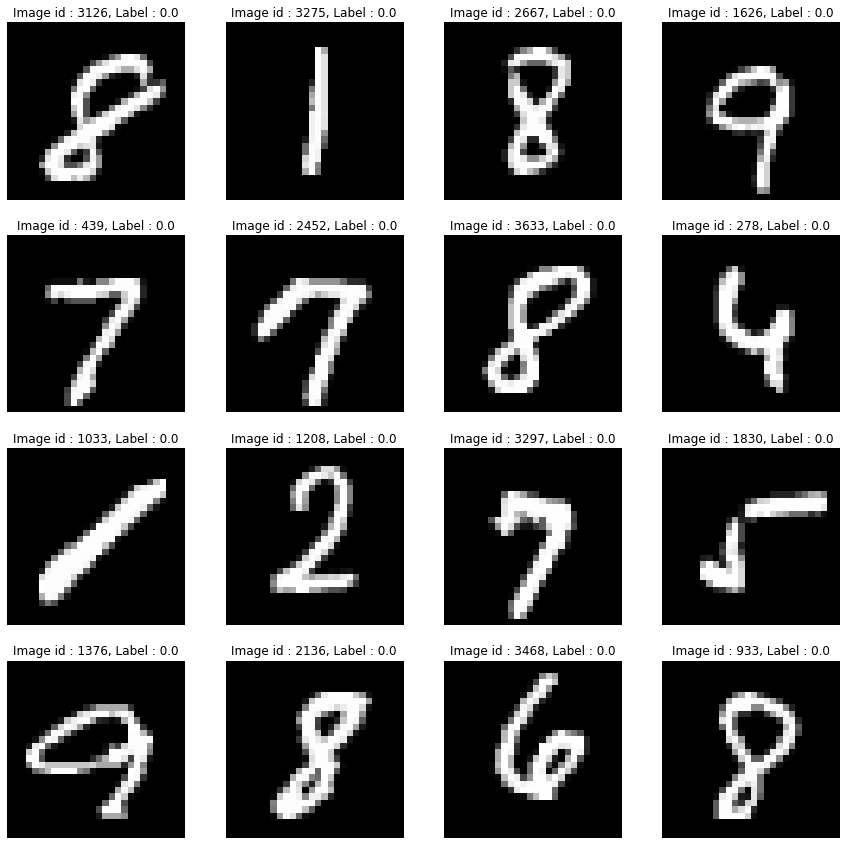

In [8]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
indices = np.random.randint(0,len(train_x),size=16)

ax = plt.subplots(4,4,figsize=(15,15))[1].flatten()

for n,idx in enumerate(indices):
    ax[n].imshow(train_x[idx].reshape(28,28),cmap=plt.cm.gray)
    ax[n].set_title(f"Image id : {idx}, Label : {train_y[idx][0]}") 
    ax[n].axis('off')

## Building up parts of our classifier

**Activation functions**

In [9]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0,z)

def relu_deriv(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    derivative of relu applied to each element of z
    """
    return np.array(z>0,dtype='float')

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    return np.exp(z)/np.sum(np.exp(z),axis=0)

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [10]:
def init_params(input_size, hidden_size, output_size):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    w0 = np.random.standard_normal(size=(hidden_size,input_size))
    b0 = np.zeros(shape=(hidden_size,1))
    w1 = np.random.standard_normal(size=(output_size,hidden_size))
    b1 = np.zeros(shape=(output_size,1))
    params = {
        "w0": w0,
        "b0": b0,
        "w1": w1,
        "b1": b1
    }

    return params

**Forward Propagation**

In [11]:
def forward_prop(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    w0, b0, w1, b1 = weights.values()
    z0 = np.dot(w0,X) + b0
    a0 = relu(z0)
    z1 = np.dot(w1,a0) + b1
    a1 = softmax(z1)
    out_dict = {
        "z0": z0,
        "a0": a0,
        "z1": z1,
        "a1": a1
    }

    return out_dict

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [12]:
def cost_func(a,y):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    # print(y,a,np.log(a))
    m = y.shape[0]
    # print(y.shape[1])
    return -(1/m)*np.sum((y.T)*np.log(a))

In [13]:
# params = init_params(train_x.shape[1],250,10)
# fprop = forward_prop(train_x.T,params)
# z0,a0,z1,a1 = fprop.values()
# print(z0.shape,a0.shape,z1.shape,a1.shape)
# w0,b0,w1,b1 = params.values()
# print(w0.shape,b0.shape,w1.shape,b1.shape)
# m = train_x.shape[0]
# dz1 = a1 - train_y.T
# dw1 = (1/m)*np.dot(dz1,a0.T)
# db1 = (1/m)*np.sum(dz1,axis=1,keepdims=True)

# dz0 = (1/m)*np.dot(w1.T,dz1)*relu_deriv(z0)
# dw0 = (1/m)*np.dot(dz0,train_x)
# db0 = (1/m)*np.sum(dz0,axis=1,keepdims=True)

In [14]:
def backward_prop(params, x, y, fprop, lr):
    """
    updates params using gradient descent and returns updated params
    """
    z0, a0, z1, a1 = fprop.values()
    w0, b0, w1, b1 = params.values()
    m = x.shape[0]

    # out to hidden
    dz1 = a1 - y.T
    dw1 = (1/m)*np.dot(dz1,a0.T)
    db1 = (1/m)*np.sum(dz1,axis=1,keepdims=True)

    # hidden to in
    dz0 =  (1/m)*np.dot(w1.T,dz1)*relu_deriv(z0)
    dw0 = (1/m)*np.dot(dz0,x)
    db0 = (1/m)*np.sum(dz0,axis=1,keepdims=True)
    
    # update params
    w0 -= lr*dw0
    b0 -= lr*db0
    w1 -= lr*dw1
    b1 -= lr*db1

    updated = {
        "w0": w0,
        "b0": b0,
        "w1": w1,
        "b1": b1
    }
    
    return updated


## Integrate everything

In [15]:
from tqdm.notebook import tqdm_notebook as pbar
def train(x, y, hidden_size, epochs=1000, lr=1e-5):
    """
    hidden_size: no. of nodes in hidden layer

    returns the updated optimize weights
    """
    lr_ = np.copy(lr)
    # initialize weights.
    params = init_params(x.shape[1],hidden_size,y.shape[1])
    # w0,b0,w1,b1 = params.values(); print(w0.shape,b0.shape,w1.shape,b1.shape)
    costs = []
    lrs = []

    progress = pbar(range(epochs))
    for epoch in range(epochs):
        # forward propagation
        state = forward_prop(x.T, params)
        cost = cost_func(state['a1'],y)
        costs.append(cost)

        # backward propagation
        params = backward_prop(params, x, y, state, lr)

        # print cost at every 100 or so iterations
        if epoch % (epochs/10) == 0:
            print(f"Epoch {str(epoch).zfill(4)}/{epochs} | Cost =",cost)
        
        if epoch > epochs*0.6:
            lr = lr_ + (1e-3 - lr_)*(epoch-epochs*0.6)/(epochs*0.6)

        progress.set_postfix_str(f"Cost = {cost:.4f} | Learning Rate : {lr:.6f}")
        progress.update()
        lrs.append(lr)
    return costs, lrs, params

In [16]:
costs, learning_rates, params = train(train_x,train_y,120,2000,0.1)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0000/2000 | Cost = 117.14084075867679
Epoch 0200/2000 | Cost = 3.7530479885925985
Epoch 0400/2000 | Cost = 2.269733142732975
Epoch 0600/2000 | Cost = 1.6292095080035556
Epoch 0800/2000 | Cost = 1.3384048017243504
Epoch 1000/2000 | Cost = 1.2007492277578422
Epoch 1200/2000 | Cost = 0.8423407584024136
Epoch 1400/2000 | Cost = 0.7714437071051052
Epoch 1600/2000 | Cost = 0.6136747267378049
Epoch 1800/2000 | Cost = 0.5563811792249529


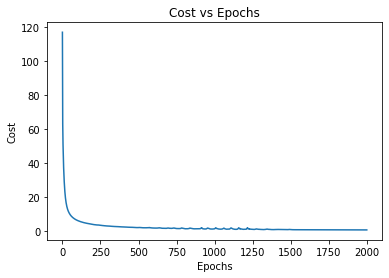

In [17]:
plt.plot(costs)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")
plt.show()

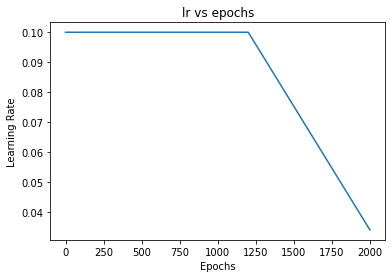

In [18]:
plt.plot(learning_rates)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("lr vs epochs")
plt.show()

In [25]:
def predict(x, weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    state = forward_prop(x.T,weights)
    outp = state['a1']
    predictions = np.argmax(outp,axis=0)
    return predictions

In [28]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    y = np.array([np.argmax(i) for i in y])
    return np.mean(predictions==y)*100

In [31]:
predictions = predict(test_x, params)
print(f"Accuracy on the test dataset = {accuracy(predictions,test_y):.2f}%")

Accuracy on the test dataset = 81.00%


### Save as pickle

In [38]:
import pickle
import random
# from google.colab import files

roll_num = "20D070021" # enter ldap
hidden_dim = 120 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': params['w0'].T, # layer 0 weight (784, z)
    'layer_0_bias': params['b0'], # layer 0 bias (z, 1)
    'layer_1_wt': params['w1'].T, # layer 1 weight (z, 10)
    'layer_1_bias': params['b1'] # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    # files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission